Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-14
   node   x   y  a    b  load
0    p0  92  86  0  999    44
1    p1  55  77  0  999    25
2    p2   0   4  0  999    50
3    p3  11  21  0  999     8
4    p4  68  13  0  999    90
5    p5  34  90  0  999    66
6    p6  48  38  0  999    60
7    d0  21  34  0  999   -44
8    d1  67  39  0  999   -25
9    d2  14  17  0  999   -50
10   d3  70  14  0  999    -8
11   d4  59  48  0  999   -90
12   d5  99  39  0  999   -66
13   d6  11  50  0  999   -60
14   o0  98  31  0  999     0
15   o1  90  95  0  999     0
16   o2  19  67  0  999     0
17   e0  83  47  0  999     0
18   e1  62  17  0  999     0
19   e2   6  66  0  999     0
20   t0  44  29  0  999     0
21   t1  94  20  0  999     0
22   t2  14  80  0  999     0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4910MQ CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical pro

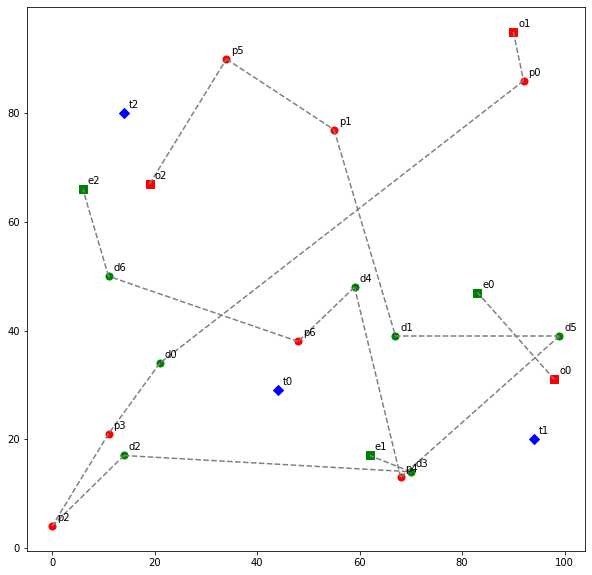

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import csv 

import gurobipy as gp
from gurobipy import GRB

filename = "./PDPT2/PDPT-R7-K3-T3-Q100-9.txt"

# Read the meta-data of problem (number of requests, number of vehicles, number of transport stations, capability of vehicles)
def readMetaData(filename):
    metaData = pd.read_csv(filename, nrows=2, sep= '\t', on_bad_lines='skip')
    return metaData

# Read the instance's data (name of node, location (x, y), time-windows, load of the request)
def readDataframe(filename):
    df = pd.read_csv(filename, skiprows=3, sep='\t')
    return df

# Calculate the Euclid-distance between locations
def calculateDistance(x1, x2, y1, y2):
    return math.sqrt((x2 - x1)**2 + (y2-y1)**2)

# Generate distance-matrix between locations
def distancesMatrix(df):
    matrix = {}
    for location1 in df["node"]:
        for location2 in df["node"]:
            if location1 != location2:
                x1 = df.loc[df["node"]==location1, 'x']
                x2 = df.loc[df["node"]==location2, 'x']
                y1 = df.loc[df["node"]==location1, 'y']
                y2 = df.loc[df["node"]==location2, 'y']
                matrix[location1, location2] = calculateDistance(int(x1), int(x2), int(y1), int(y2))
    return matrix

# Generate dictionary of (node:load)
def loadDict(df):
    matrix = {}
    for location in df["node"]:
        matrix[location] = df.loc[df["node"]==location, 'load'].values[0]
    return matrix

# Get the list of grouped nodes
def getNodeList(df):
    rOrigins = df.loc[df['node'].str.contains('p'),'node']
    rDestinations = df.loc[df['node'].str.contains('d'),'node']
    vOrigins = df.loc[df['node'].str.contains('o'),'node']
    vDestinations = df.loc[df['node'].str.contains('e'),'node']
    transferNodes = df.loc[df['node'].str.contains('t'),'node']
    return [rOrigins, rDestinations, vOrigins, vDestinations, transferNodes]
def calculateDistance(x1, x2, y1, y2):
    return math.sqrt((x2 - x1)**2 + (y2-y1)**2)

# one unit of distance can be traveled in one time unit
def distancesMatrix(df):
    matrix = {}
    for location1 in df["node"]:
        matrix[location1] = {}
        for location2 in df["node"]:
            if location1 != location2:
                x1 = df.loc[df["node"]==location1, 'x'].values[0]
                x2 = df.loc[df["node"]==location2, 'x'].values[0]
                y1 = df.loc[df["node"]==location1, 'y'].values[0]
                y2 = df.loc[df["node"]==location2, 'y'].values[0]
                matrix[location1][location2] = calculateDistance(int(x1), int(x2), int(y1), int(y2))
    return matrix

def loadMatrix(df):
    matrix = {}
    for location in df["node"]:
        matrix[location] = df.loc[df["node"]==location, 'load'].values[0]
    return matrix

def getNodeList(df):
    allNodes = df['node']
    rOrigins = df.loc[df['node'].str.contains('p'),'node']
    rDestinations = df.loc[df['node'].str.contains('d'),'node']
    vOrigins = df.loc[df['node'].str.contains('o'),'node']
    vDestinations = df.loc[df['node'].str.contains('e'),'node']
    transferNodes = df.loc[df['node'].str.contains('t'),'node']
    return {"a":allNodes, "ro":rOrigins, "rd":rDestinations, "vo":vOrigins, "vd":vDestinations, "t":transferNodes}



# Model, Parameters, Variables and Objective Function
model = gp.Model()
metaData = readMetaData(filename)
df = readDataframe(filename)
nodeList = getNodeList(df)

# # Testing Symmetries Breaking Constraints
# df.loc[df['node'].str.contains('o'), 'x'] = 50
# df.loc[df['node'].str.contains('o'), 'y'] = 50
# df.loc[df['node'].str.contains('e'), 'x'] = 50
# df.loc[df['node'].str.contains('e'), 'y'] = 50

nRequests = int(metaData['nr'])
nVehicles = int(metaData['nv'])
nTransports = int(metaData['nt'])
vCapability = int(metaData['capacity'])

c = pd.DataFrame.from_dict(distancesMatrix(df)).fillna(0)
k = pd.RangeIndex(nVehicles)
r = pd.RangeIndex(nRequests)
u = pd.Series(index=k, data=np.full(nVehicles, vCapability))
q = pd.Series(index = np.concatenate((nodeList['ro'].values, nodeList['rd'].values)), data=df.loc[0:nRequests*2-1,'load'].values, dtype=int)

print(df)

xIndex = [(k, i, j) for k in pd.RangeIndex(nVehicles) for i in nodeList['a'].values for j in nodeList['a'].values if i != j]
yIndex = [(k, r, i, j) for k in pd.RangeIndex(nVehicles) for r in pd.RangeIndex(nRequests) for i in nodeList['a'].values for j in nodeList['a'].values if i != j]
sIndex = [(k1, k2, t, r) for k1 in pd.RangeIndex(nVehicles) for k2 in pd.RangeIndex(nVehicles) for t in nodeList['t'].values for r in pd.RangeIndex(nRequests) if k1 != k2]
aIndex = [(k, i) for k in pd.RangeIndex(nVehicles) for i in nodeList['a'].values]
bIndex = [(k, i) for k in pd.RangeIndex(nVehicles) for i in nodeList['a'].values]

x = model.addVars(xIndex, vtype=GRB.BINARY, name='x')
y = model.addVars(yIndex, vtype=GRB.BINARY, name='y')
s = model.addVars(sIndex, vtype=GRB.BINARY, name='s')
a = model.addVars(aIndex, vtype=GRB.INTEGER, name='a')
b = model.addVars(bIndex, vtype=GRB.INTEGER, name='b')

model.setObjective(sum((c[i][j] * x[k, i, j]) for i in nodeList['a'].values for j in nodeList['a'].values for k in pd.RangeIndex(nVehicles) if i != j), GRB.MINIMIZE)
model.update()



# Constraints

# Constraints (25), (27), (42) ensure vehicle flow
for k in pd.RangeIndex(nVehicles):
    for i in nodeList['vo'].values:
        if 'o' + str(k) == i:
            # all of vehicles must leave its origin depot
            model.addConstr(sum(x[k, i, j] for j in nodeList['a'].values if j != i) == 1, name="constr25")
    
    for i in nodeList['vd'].values:
        if 'e'+ str(k) == i:
            # the vehicle must end its route at its destination depot
            model.addConstr(sum(x[k, j, i] for j in nodeList['a'] if i != j) == 1, name='constr42')        
            
    for i in np.concatenate((nodeList['ro'].values, nodeList['rd'].values, nodeList['t'].values)):    
        # excluding vehicle's origin and destination, if a vehicle go in a node, it must go out this node
        model.addConstr(sum(x[k, i, j] for j in nodeList['a'].values if i != j) - sum(x[k, j, i] for j in nodeList['a'].values if i != j) == 0, name='constr27')
        
    # # TODO: Is it redundant?
    # for i in nodeList['a'].values:
    #     model.addConstr(a[k, i] >= 0, name='constr33')
    #     model.addConstr(b[k, i] >= 0, name='constr33')
        
# Constaints (4), (5), (6), (16) are used to maintain the request flow              
for r in pd.RangeIndex(nRequests):
    for i in nodeList['a'].values:
        if i in nodeList['ro'].values:
            if 'p' + str(r) == i:
                # only one vehicle can pickup the request at request's origin
                model.addConstr(sum(sum(y[k, r, i, j] for j in nodeList['a'].values if i != j) for k in pd.RangeIndex(nVehicles)) == 1, name="constr4")
                
        if i in nodeList['rd'].values:
            if 'd' + str(r) == i:
                # only one vehicle can drop off the request at request's destination
                model.addConstr(sum(sum(y[k, r, j, i] for j in nodeList['a'].values if i != j) for k in pd.RangeIndex(nVehicles)) == 1, name="constr5")
                
        if i in nodeList['t'].values:
            # the total number of request go in and out at a specific transfer node must be equal
            model.addConstr(sum(sum(y[k, r, i, j] for j in nodeList['a'].values if i != j) for k in pd.RangeIndex(nVehicles)) == sum(sum(y[k, r, j, i] for j in nodeList['a'].values if i != j) for k in pd.RangeIndex(nVehicles)), name="constr6")   
        
        for k in pd.RangeIndex(nVehicles):
            if i not in [node for node in nodeList['ro'].values if 'p' + str(r) == node] and i not in [node for node in nodeList['rd'].values if 'd' + str(r) == node] and i not in nodeList['t'].values:
                # request must be delivered by a same vehicle when it go throught a node other than its origin or destination or a transfer node
                model.addConstr(sum(y[k, r, i, j] for j in nodeList['a'].values if i != j) == sum(y[k, r, j, i] for j in nodeList['a'].values if i != j), name="constr16")


for i in nodeList['a'].values:
    for j in nodeList['a'].values:
        for k in pd.RangeIndex(nVehicles):
            if i != j:
                for r in pd.RangeIndex(nRequests):
                    # synchronisation between vehicle flow and request flow
                    model.addConstr(y[k, r, i, j] <= x[k, i, j], name="constr8")
                    
                # capacity constraint
                model.addConstr(sum((q[r]*y[k, r, i, j]) for r in pd.RangeIndex(nRequests)) <= u[k]*x[k, i, j], name="constr9")

# maintain the synchronisation at transfer nodes
for r in pd.RangeIndex(nRequests):
    for t in nodeList['t'].values:
        M = int(df.loc[df['node'] == t, 'b'].values[0]) - int(df.loc[df['node'] == t, 'a'].values[0])
        for k1 in pd.RangeIndex(nVehicles):
            for k2 in pd.RangeIndex(nVehicles):
                if k1 != k2:
                    # maintain the synchronisation variables at transfer nodes
                    model.addConstr(sum(y[k1, r, j, t] for j in nodeList['a'].values if j != t) + sum(y[k2, r, t, j] for j in nodeList['a'].values if j != t) <= (s[k1, k2, t, r] + 1), name='constr21')
                    
                    # maintain the synchronisation time-window at transfer nodes
                    model.addConstr(a[k1, t] - b[k2, t] <= M * (1 - s[k1, k2, t, r]), name='constr48')
                
# (49)-(51) ensure that the requests are picked up and delivered in the given time windows
for i in nodeList['a'].values:
    for k in pd.RangeIndex(nVehicles):
        for j in nodeList['a'].values:
            if i != j:
                M = max(0, df.loc[df['node'] == i, 'b'].values[0]) + c[i][j] - int(df.loc[df['node'] == j, 'a'].values[0])
                model.addConstr(b[k, i] + c[i][j] - a[k, j] <= M * (1 - x[k, i, j]), name='constr49')
        
        model.addConstr(a[k, i] >= int(df.loc[df['node'] == i, 'a'].values[0]), name='constr50a')
        model.addConstr(b[k, i] <= int(df.loc[df['node'] == i, 'b'].values[0]), name='constr50b')
        model.addConstr(a[k, i] <= b[k, i], name='constr51')      

# Constraints (40)-(47) are valid inequalities
for k in pd.RangeIndex(nVehicles):        
    for i in nodeList['vo'].values:
        if 'o' + str(k) == i:
            # the vehicles cannot go back to the origin depots
            model.addConstr(sum(x[k, j, i] for j in nodeList['a'].values if j != i) == 0, name="constr40")
            
    for i in [node for node in np.concatenate((nodeList['vo'].values, nodeList['vd'].values))]:
        if i not in [node for node in nodeList['vo'].values if 'o' + str(k) == node]:
            # avoid departure of vehicle from a position other than its origin
            model.addConstr(sum(x[k, i, j] for j in nodeList['a'].values if i != j) == 0, name='constr41')
            
    for i in nodeList['vd'].values:
        if 'e' + str(k) == i:
            # the vehicle does not leave its destination depot
            model.addConstr(sum(x[k, i, j] for j in nodeList['a'] if i != j) == 0, name='constr43')
        
    for i in nodeList['t'].values:
        # each vehicle visits the same transfer station at most once
        model.addConstr(sum(x[k, i, j] for j in nodeList['a'].values if i != j) <= 1, name='constr44')

for i in np.concatenate((nodeList['ro'].values, nodeList['rd'].values)):
    # the pickup locations and delivery locations are visited only once.
    model.addConstr(sum(sum(x[k, i, j] for k in pd.RangeIndex(nVehicles)) for j in nodeList['a'].values if i != j) == 1, name='constr45')
    
for r in pd.RangeIndex(nRequests):
    for j in nodeList['ro'].values:
        if 'p' + str(r) == j:       
            # Restrict that the request flows should not contain arcs that head to the pickup locations
            model.addConstr(sum(sum(y[k, r, i, j] for k in pd.RangeIndex(nVehicles)) for i in nodeList['a'].values if i != j) == 0, name='constr46')      

for r in pd.RangeIndex(nRequests):
    for k in pd.RangeIndex(nVehicles):
        for i in np.concatenate((nodeList['vo'].values, nodeList['vd'].values)):
            if i not in [node for node in np.concatenate((nodeList['vo'].values, nodeList['vd'].values)) if (('o'+str(+ k) == node) or ('e' + str(k) == node))]:
                # the request flows should not include the origin depots or destination depots
                model.addConstr(sum(y[k, r, i, j] for j in nodeList['a'].values if i != j) == 0, name='constr47')                    

# Proposing constraints
    
# Cortes (2010) symmetries breaking constraints        
# for r in pd.RangeIndex(nRequests):
#     # Symmetries Breaking Constraints form Cortes (2010)
#     model.addConstr(sum(sum(y[k, r, i, j] for i in nodeList['vo'].values if ('o' + str(r) == i) for j in nodeList['a'].values if i != j) for k in pd.RangeIndex(nVehicles) if k > r) == 0, name='symmetries breaking constr')


# Constraint for synchronisation at transfer points
for r in pd.RangeIndex(nRequests):
    for t in nodeList['t'].values:
        for k1 in pd.RangeIndex(nVehicles):
            for k2 in pd.RangeIndex(nVehicles):
                if k1 != k2:
                    model.addConstr(sum(y[k1, r, j, t] for j in nodeList['a'].values if j != t) + sum(y[k2, r, t, j] for j in nodeList['a'].values if j != t) >= 2 * s[k1, k2, t, r], name='new1')
#         model.addConstr(sum(s[k1, k2, t, r] for k1 in pd.RangeIndex(nVehicles) for k2 in pd.RangeIndex(nVehicles) if k1 != k2) <= 1, name='newSynConstr2')        

# for r in pd.RangeIndex(nRequests):
#     for t in nodeList['t'].values:
#         M = int(df.loc[df['node'] == t, 'b'].values[0]) - int(df.loc[df['node'] == t, 'a'].values[0])
#         for k1 in pd.RangeIndex(nVehicles):
#             for k2 in pd.RangeIndex(nVehicles):
#                 if k1 != k2:
#                     # sencond constraint to maintaintime-window at transfer nodes if the transfer can only carried out if two vehicle present at transfer node at the same time
#                     model.addConstr(a[k2, t] - b[k1, t] <= M * (1 - s[k1, k2, t, r]), name='new2')

# Valid cuts

for r in pd.RangeIndex(nRequests):
    for t in nodeList['t'].values:
        for k1 in pd.RangeIndex(nVehicles):
            for k2 in pd.RangeIndex(nVehicles):
                if k1 != k2:
                    # if a vehicle pickup an request at a transfer point, it can not go direct to  destination depots   
                    model.addConstr(sum(x[k2, t, i] for i in nodeList['vd'].values) <= 1 - s[k1, k2, t, r], name="valid1")

for r in pd.RangeIndex(nRequests):
    for k in pd.RangeIndex(nVehicles):
        for i in np.concatenate((nodeList['vo'].values, nodeList['vd'].values)):
            if i not in [node for node in np.concatenate((nodeList['vo'].values, nodeList['vd'].values)) if (('o' + str(k) == node) or ('e' + str(k) == node))]:
                # the request flows should not include the origin depots or destination depots
                model.addConstr(sum(y[k, r, j, i] for j in nodeList['a'].values if i != j) == 0, name='valid2')      

# for r in pd.RangeIndex(nRequests):
#     for t in nodeList['t'].values:
#         for k1 in pd.RangeIndex(nVehicles):
#             for k2 in pd.RangeIndex(nVehicles):
#                 if k1 != k2:
#                     # if a vehicle pickup an request at a transfer point, it can not go direct to  destination depots   
#                     model.addConstr(sum(x[k1, i, t] for i in nodeList['vo'].values) <= 1 - s[k1, k2, t, r], name="valid3")

for i in nodeList['ro'].values:
    for j in nodeList['vd'].values:
        model.addConstr(sum(x[k, i, j] for k in pd.RangeIndex(nVehicles)) == 0, name='valid4')

for i in nodeList['vo'].values:
    for j in nodeList['rd'].values:
        model.addConstr(sum(x[k, i, j] for k in pd.RangeIndex(nVehicles)) == 0, name='valid5')


model.update()
model.optimize()
# model.computeIIS()
# model.write("model.ilp")

def plotLocation(df):
    fig, axes = plt.subplots(figsize=(10, 10))
    
    plt.scatter(df.loc[df['node'].str.contains('p'),'x'].values, df.loc[df['node'].str.contains('p'),'y'].values, s=50, facecolor='red', marker='o')
    plt.scatter(df.loc[df['node'].str.contains('d'),'x'].values, df.loc[df['node'].str.contains('d'),'y'].values, s=50, facecolor='green', marker='o')
    plt.scatter(df.loc[df['node'].str.contains('o'),'x'].values, df.loc[df['node'].str.contains('o'),'y'].values, s=50, facecolor='red', marker='s')
    plt.scatter(df.loc[df['node'].str.contains('e'),'x'].values, df.loc[df['node'].str.contains('e'),'y'].values, s=50, facecolor='green', marker='s')
    plt.scatter(df.loc[df['node'].str.contains('t'),'x'].values, df.loc[df['node'].str.contains('t'),'y'].values, s=50, facecolor='blue', marker='D')
    
    for xi, yi, text in zip(df['x'].values, df['y'].values, df['node'].values):
        plt.annotate(text, xy=(xi, yi), xycoords='data', xytext=(5, 5), textcoords='offset points')
    count = 0
    xResult = pd.DataFrame(x.keys(), columns=["k","i","j"])
    xResult["value"]=model.getAttr("X", x).values()
    
    for index, row in xResult.iterrows():
        if row["value"] == 1:
            x1 = df.loc[df['node'] == row["i"], 'x'].values
            y1 = df.loc[df['node'] == row["i"], 'y'].values
            x2 = df.loc[df['node'] == row["j"], 'x'].values
            y2 = df.loc[df['node'] == row["j"], 'y'].values
            plt.plot([x1, x2], [y1, y2], 'gray', linestyle="--")
    plt.show()
plotLocation(df)



In [2]:
sResult = pd.DataFrame(s.keys(), columns=["k1","k2","t","r"])
sResult["value"]=model.getAttr("X", s).values()